In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

import warnings
warnings.filterwarnings('ignore')

# Preprocessing

In [2]:
train = pd.read_csv('train.csv' , sep = '\t').drop( columns = 'Unnamed: 0')
test = pd.read_csv('test.csv', sep = '\t').drop( columns = 'Unnamed: 0')

print('size :' + str(train.shape))
print('trget % :' + str(train['0'].value_counts(normalize =True)[1]))
train.head()

size :(30500, 346)
trget % :0.17780327868852458


,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,345
0,1,1,0,0,0,0,0,0.090909,0,0,...,0.221395,0,1,0,0,0.222222,1,1,1,1
1,1,1,0,0,1,0,0,0.090909,0,0,...,0.241508,0,1,0,0,0.111111,1,1,1,0
2,0,1,0,0,1,0,0,0.090909,0,0,...,0.123067,0,1,0,0,0.444444,1,1,1,1
3,0,1,0,0,1,0,0,0.136364,0,0,...,0.296065,0,0,1,0,0.222222,1,1,1,0
4,0,1,0,0,1,0,0,0.136364,0,0,...,0.178956,0,0,1,0,0.111111,1,1,1,1


In [3]:
for column in train.columns[1:]  :
    delIndex = train.index[ (train[column] < test[column].min()) | (test[column].max() < train[column] )  ]
    train.drop( delIndex , inplace= True )
    
badCol = train.columns[[train[col].unique().size == 1 for col in train.columns ]]   
train.drop(columns = badCol , inplace = True )
test.drop(columns = badCol , inplace = True )
train.reset_index(drop=True , inplace= True)

print('size :' + str(train.shape))
print('trget % :' + str(train['0'].value_counts(normalize =True)[1]))
train.head()

size :(30254, 324)
trget % :0.17805909962319033


,0,1,2,3,4,6,7,8,9,10,...,336,337,338,339,340,341,342,343,344,345
0,1,1,0,0,0,0,0.090909,0,0,1,...,0.221395,0,1,0,0,0.222222,1,1,1,1
1,1,1,0,0,1,0,0.090909,0,0,1,...,0.241508,0,1,0,0,0.111111,1,1,1,0
2,0,1,0,0,1,0,0.090909,0,0,1,...,0.123067,0,1,0,0,0.444444,1,1,1,1
3,0,1,0,0,1,0,0.136364,0,0,1,...,0.296065,0,0,1,0,0.222222,1,1,1,0
4,0,1,0,0,1,0,0.136364,0,0,1,...,0.178956,0,0,1,0,0.111111,1,1,1,1


In [4]:
#ppReportTrain = pp.ProfileReport(train)

In [5]:
#ppReportTrain

In [6]:
train.drop(columns = ['9', '153'] , inplace = True )
test.drop(columns = ['9', '153'] , inplace = True )
#corColumns = ppReportTrain.get_rejected_variables()
corColumns = ['117', '119', '122', '128', '146', '148', '153', '158', '165', '179', '180', 
              '206', '323', '324', '325', '326', '327', '333', '334', '335', '341', '9']
corColumns.remove('9')
corColumns.remove('153')

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold , cross_val_score , GridSearchCV
X = train.drop(columns = ['0'])
y = train['0'].astype(int)
test_X = test.drop(columns = '0')
skf = StratifiedKFold(n_splits = int(train.shape[0]/test.shape[0] ), shuffle=True, random_state=42)
# пребором (из тех где больше всего уникальных значений)
cat_cols =[ '114', '196', '197', '198', '199',  '201', '202', '203',
           '204', '205', '206', '207', '208', '209', '210','109']

# Val

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

class Check_score:
    def __init__(self , startData , y , skf):
        self.skf = skf
        self.lr= LogisticRegression()
        self.rf = RandomForestClassifier( 
                            max_depth= 30, 
                            min_samples_split= 100,
                            n_estimators= 25 , 
                            random_state=42 , 
                            n_jobs = -1 )
        
        self.lgb_param = {
                            'objective': 'binary',
                            'learning_rate': 0.1,
                            'num_threads': -1,
                            "metric": 'auc',

                            'colsample_bytree': 0.7,
                            'subsample': 0.7,
                            'subsample_freq': 1 ,
                        }
        
        self.xgb_param = {
                            'objective': 'binary:logistic',
                            'eta': 0.1, 
                            'silent': 1,
                            "nthread": -1,
                            "random_seed": 42,
                            "eval_metric": 'auc',

                            'subsample': 0.7,
                            'colsample_bytree': 0.7,

                            'tree_method': 'hist',
                            'grow_policy': 'lossguide',
                            'predictor':'cpu_predictor'
                        }
        self.lr_score ,  self.rf_score , self.lgb_score , self.xgb_score = self.data_score( startData , y)
        
        
       
        
        
    def data_score(self , data , y):
        lr_score = cross_val_score( self.lr , data , y  ,cv =self.skf , scoring = 'roc_auc' , n_jobs = -1).mean()
        rf_score = cross_val_score( self.rf , data , y  ,cv =self.skf , scoring = 'roc_auc' , n_jobs = -1).mean()
        
        lgb_result = lgb.cv( self.lgb_param, lgb.Dataset(data , label=y) , 10000, 
                                  folds=self.skf.split(data, y), early_stopping_rounds=10,)
        lgb_score =  max(lgb_result['auc-mean'])
        
        xgb_results = xgb.cv(self.xgb_param, xgb.DMatrix(data, y), 10000,
                            folds= list(self.skf.split(data,y)), early_stopping_rounds=10 ,)
        xgb_score = max(xgb_results['test-auc-mean'])
        
        return lr_score ,  rf_score , lgb_score , xgb_score
       
    def get_start_score(self):
        print('lr : ' + str(self.lr_score )  )
        print('rf : ' + str(self.rf_score )  )
        print('lgb : ' + str(self.lgb_score ) )
        print('xgb : ' + str(self.xgb_score ) )
    
    def check_newData(self ,newData , y):
        new_score = np.array(self.data_score( newData , y))
        print('lr : ' + str(new_score[0] -  self.lr_score ) + ' (' +str(new_score[0]) +')' )
        print('rf : ' + str(new_score[1] -  self.rf_score ) + ' (' +str(new_score[1]) +')' )
        print('lgb : ' + str( new_score[2] - self.lgb_score ) + ' (' +str(new_score[2]) +')' )
        print('xgb : ' + str( new_score[3] - self.xgb_score ) + ' (' +str(new_score[3]) +')' )

check_score =  Check_score(X , y , skf)
check_score.get_start_score()

lr : 0.7255487566237326
rf : 0.7164838026573015
lgb : 0.7364724417974662
xgb : 0.7383938571428572


###### standart xgb score

In [132]:
xgb_parameters = {
    #default
    'objective': 'binary:logistic',
    'eta': 0.01, 
    'silent': 1,
    "nthread": -1,
    "random_seed": 42,
    "eval_metric": 'auc',
    
    # regularization parameters
    'max_leaves': 80,
    'max_depth': 24,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    
    #lightgbm approach
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'predictor':'cpu_predictor'
}
xgb_train = xgb.DMatrix(X, y)

results = xgb.cv(xgb_parameters, xgb_train, 10000,folds= list(skf.split(X,y)), 
                 early_stopping_rounds=100 ,verbose_eval=1)

xgb_rounds = pd.Series( results['test-auc-mean']).idxmax()+1
max(results['test-auc-mean']) , xgb_rounds

[0]	train-auc:0.710583+0.00509006	test-auc:0.682798+0.00536919
[1]	train-auc:0.730764+0.00323305	test-auc:0.699622+0.00398307
[2]	train-auc:0.74009+0.00520836	test-auc:0.706148+0.00695201
[3]	train-auc:0.744767+0.00393073	test-auc:0.709587+0.00859276
[4]	train-auc:0.748064+0.00374035	test-auc:0.710532+0.00815381
[5]	train-auc:0.751362+0.00353667	test-auc:0.713591+0.00835864
[6]	train-auc:0.752981+0.00370225	test-auc:0.713197+0.00776267
[7]	train-auc:0.754182+0.00392579	test-auc:0.71375+0.00726191
[8]	train-auc:0.755492+0.00431341	test-auc:0.714362+0.00665454
[9]	train-auc:0.756196+0.00454359	test-auc:0.714506+0.00634972
[10]	train-auc:0.757159+0.0042296	test-auc:0.715106+0.00634478
[11]	train-auc:0.757774+0.00450023	test-auc:0.715397+0.00660825
[12]	train-auc:0.758828+0.00416512	test-auc:0.715992+0.00579798
[13]	train-auc:0.759864+0.00386591	test-auc:0.716851+0.00569047
[14]	train-auc:0.760911+0.00371565	test-auc:0.717284+0.0062343
[15]	train-auc:0.761508+0.00380699	test-auc:0.718082+0

[129]	train-auc:0.801949+0.00177717	test-auc:0.730796+0.00583847
[130]	train-auc:0.802244+0.00175064	test-auc:0.730827+0.00588809
[131]	train-auc:0.802623+0.00175888	test-auc:0.730929+0.00590608
[132]	train-auc:0.802995+0.00177171	test-auc:0.730979+0.00587872
[133]	train-auc:0.803368+0.00167082	test-auc:0.731157+0.00593286
[134]	train-auc:0.803661+0.00159269	test-auc:0.731225+0.00593555
[135]	train-auc:0.804+0.00162115	test-auc:0.731253+0.00591454
[136]	train-auc:0.804335+0.0016654	test-auc:0.731309+0.0059274
[137]	train-auc:0.80477+0.00169646	test-auc:0.7314+0.0059329
[138]	train-auc:0.805158+0.00167248	test-auc:0.73153+0.00593779
[139]	train-auc:0.805554+0.00161396	test-auc:0.731619+0.00596772
[140]	train-auc:0.805967+0.00162318	test-auc:0.731711+0.00599147
[141]	train-auc:0.806417+0.00164855	test-auc:0.731803+0.00596146
[142]	train-auc:0.806614+0.00165381	test-auc:0.731821+0.00594992
[143]	train-auc:0.806964+0.00168438	test-auc:0.731873+0.00594852
[144]	train-auc:0.807268+0.00177165

[257]	train-auc:0.848745+0.00107721	test-auc:0.739137+0.00693125
[258]	train-auc:0.849085+0.00106605	test-auc:0.739192+0.00691864
[259]	train-auc:0.849386+0.0010627	test-auc:0.739221+0.006955
[260]	train-auc:0.849693+0.00104478	test-auc:0.739267+0.00698909
[261]	train-auc:0.85004+0.00105367	test-auc:0.739288+0.00702186
[262]	train-auc:0.850415+0.00103994	test-auc:0.739362+0.00697535
[263]	train-auc:0.85078+0.00103717	test-auc:0.739409+0.00698363
[264]	train-auc:0.851141+0.0010343	test-auc:0.739461+0.0070226
[265]	train-auc:0.851492+0.00104536	test-auc:0.739551+0.00706543
[266]	train-auc:0.85184+0.00106303	test-auc:0.739543+0.00707643
[267]	train-auc:0.852165+0.00107296	test-auc:0.739623+0.00704153
[268]	train-auc:0.852491+0.00101927	test-auc:0.739618+0.00701824
[269]	train-auc:0.852845+0.00101695	test-auc:0.739664+0.00701298
[270]	train-auc:0.853174+0.001012	test-auc:0.73971+0.00700619
[271]	train-auc:0.853507+0.000964406	test-auc:0.73975+0.00700554
[272]	train-auc:0.853876+0.000972342

[384]	train-auc:0.887803+0.00104885	test-auc:0.743228+0.00768327
[385]	train-auc:0.888053+0.00103971	test-auc:0.743254+0.00764075
[386]	train-auc:0.888334+0.00102115	test-auc:0.743285+0.00763627
[387]	train-auc:0.888592+0.00102957	test-auc:0.74328+0.00762651
[388]	train-auc:0.888847+0.00102335	test-auc:0.743331+0.00757299
[389]	train-auc:0.88912+0.00101577	test-auc:0.743339+0.00763595
[390]	train-auc:0.889374+0.00102069	test-auc:0.743321+0.00764877
[391]	train-auc:0.889643+0.0010238	test-auc:0.743344+0.00765558
[392]	train-auc:0.889892+0.00102042	test-auc:0.743354+0.00766971
[393]	train-auc:0.890157+0.00101626	test-auc:0.74339+0.00771334
[394]	train-auc:0.890397+0.00103204	test-auc:0.743493+0.0077341
[395]	train-auc:0.890664+0.00103112	test-auc:0.743488+0.00771806
[396]	train-auc:0.890922+0.0010435	test-auc:0.743496+0.00773343
[397]	train-auc:0.891192+0.00102953	test-auc:0.743528+0.00774003
[398]	train-auc:0.891426+0.00106512	test-auc:0.743542+0.00771611
[399]	train-auc:0.891676+0.0010

[510]	train-auc:0.917042+0.00080614	test-auc:0.744936+0.0080522
[511]	train-auc:0.917235+0.000806899	test-auc:0.744961+0.00806751
[512]	train-auc:0.917421+0.000810713	test-auc:0.744985+0.00807847
[513]	train-auc:0.917608+0.000816544	test-auc:0.744954+0.00809783
[514]	train-auc:0.917798+0.000810691	test-auc:0.744961+0.00802784
[515]	train-auc:0.918002+0.00080135	test-auc:0.74495+0.00805164
[516]	train-auc:0.918201+0.00079327	test-auc:0.744951+0.00803561
[517]	train-auc:0.918394+0.00079626	test-auc:0.744937+0.00805789
[518]	train-auc:0.918578+0.000800972	test-auc:0.74493+0.00803937
[519]	train-auc:0.918769+0.000805983	test-auc:0.74491+0.00804481
[520]	train-auc:0.918945+0.000805253	test-auc:0.744953+0.00802016
[521]	train-auc:0.919144+0.000798681	test-auc:0.744984+0.00806169
[522]	train-auc:0.919334+0.000812555	test-auc:0.744978+0.00806694
[523]	train-auc:0.919535+0.000808662	test-auc:0.744967+0.00807692
[524]	train-auc:0.91973+0.000822818	test-auc:0.744967+0.00809772
[525]	train-auc:0.9

[635]	train-auc:0.938074+0.000591178	test-auc:0.74551+0.00799367
[636]	train-auc:0.938204+0.000584129	test-auc:0.745513+0.00802365
[637]	train-auc:0.938339+0.000565797	test-auc:0.745523+0.00805362
[638]	train-auc:0.938476+0.00055353	test-auc:0.745545+0.00806638
[639]	train-auc:0.938619+0.000547298	test-auc:0.74554+0.00806087
[640]	train-auc:0.938761+0.000538482	test-auc:0.745562+0.00806427
[641]	train-auc:0.938907+0.000561346	test-auc:0.745552+0.00806781
[642]	train-auc:0.939075+0.000576942	test-auc:0.745533+0.00804317
[643]	train-auc:0.93919+0.000565902	test-auc:0.745586+0.00805678
[644]	train-auc:0.939338+0.000569997	test-auc:0.745581+0.00807505
[645]	train-auc:0.939479+0.000557618	test-auc:0.745571+0.00806298
[646]	train-auc:0.939622+0.000562785	test-auc:0.745582+0.00809891
[647]	train-auc:0.939769+0.000544736	test-auc:0.745586+0.00809915
[648]	train-auc:0.939908+0.000564752	test-auc:0.745589+0.00807492
[649]	train-auc:0.940051+0.000569416	test-auc:0.745583+0.00803884
[650]	train-au

[760]	train-auc:0.953621+0.000574968	test-auc:0.745607+0.0081811
[761]	train-auc:0.953738+0.000571465	test-auc:0.745587+0.00821078
[762]	train-auc:0.953841+0.000574832	test-auc:0.745592+0.00818484
[763]	train-auc:0.953944+0.000571298	test-auc:0.745598+0.00820668
[764]	train-auc:0.954044+0.000570317	test-auc:0.74559+0.00821252
[765]	train-auc:0.954152+0.00057434	test-auc:0.745592+0.00822149
[766]	train-auc:0.954262+0.000570721	test-auc:0.745582+0.00823215
[767]	train-auc:0.954364+0.000561067	test-auc:0.745597+0.00824894
[768]	train-auc:0.954477+0.000556845	test-auc:0.745608+0.00824308
[769]	train-auc:0.954595+0.00055617	test-auc:0.745594+0.00823573
[770]	train-auc:0.954689+0.000547021	test-auc:0.745575+0.00822649
[771]	train-auc:0.954777+0.000549713	test-auc:0.745572+0.00821415
[772]	train-auc:0.954891+0.0005427	test-auc:0.745584+0.00822966
[773]	train-auc:0.95499+0.00054726	test-auc:0.745555+0.00824757
[774]	train-auc:0.955098+0.000547966	test-auc:0.74553+0.00823075
[775]	train-auc:0.9

(0.7456127142857143, 749)

# 1 / Dimensionality Reduction

###### PCA

In [21]:
from sklearn.decomposition import PCA
X_PCA = pd.DataFrame( PCA(n_components= 2).fit_transform(X) )
check_score.check_newData(X_PCA , y)

lr : -0.1158076856762903 (0.6097410709474423)
rf : -0.09694827993905053 (0.619535522718251)
lgb : -0.109715614049117 (0.6267568277483492)
xgb : -0.11200614285714283 (0.6263877142857144)


In [22]:
from sklearn.decomposition import PCA
X_PCA = pd.DataFrame( PCA(n_components= 10).fit_transform(X) )
check_score.check_newData(X_PCA , y)

lr : -0.05754478435851196 (0.6680039722652207)
rf : -0.03093584708197361 (0.6855479555753279)
lgb : -0.044532631210897455 (0.6919398105865687)
xgb : -0.046613428571428694 (0.6917804285714285)


In [23]:
from sklearn.decomposition import PCA
X_PCA = pd.DataFrame( PCA(n_components= 50).fit_transform(X) )
check_score.check_newData(X_PCA , y)

lr : -0.026106396664784204 (0.6994423599589484)
rf : -0.015267660696573149 (0.7012161419607283)
lgb : -0.022739606402740642 (0.7137328353947255)
xgb : -0.023318000000000172 (0.715075857142857)


In [16]:
from sklearn.decomposition import PCA
X_PCA = pd.DataFrame( PCA(n_components= 300).fit_transform(X) )
check_score.check_newData(X_PCA , y)

lr : 5.3870631090746635e-05 (0.7256026272548234)
rf : -0.026295038029613527 (0.690188764627688)
lgb : -0.014754977644875766 (0.7217174641525904)
xgb : -0.013082857142857063 (0.7253110000000002)


###### TSNE

In [17]:
from sklearn.manifold import TSNE
X_TSNE = TSNE().fit_transform(X)
check_score.check_newData(X_TSNE , y)

lr : -0.13167681910467588 (0.5938719375190568)
rf : -0.03245105584152386 (0.6840327468157776)
lgb : -0.09409031367571852 (0.6423821281217477)
xgb : -0.09651071428571434 (0.6418831428571429)


###### UMAP

In [19]:
from umap import UMAP
X_UMAP = pd.DataFrame(UMAP( n_components= 2).fit_transform(X))
check_score.check_newData(X_UMAP , y)

lr : -0.10911930704262418 (0.6164294495811085)
rf : -0.04439882994051947 (0.672084972716782)
lgb : -0.0860485297360204 (0.6504239120614458)
xgb : -0.08867342857142857 (0.6497204285714286)


In [20]:
from umap import UMAP
X_UMAP = pd.DataFrame(UMAP( n_components= 10).fit_transform(X))
check_score.check_newData(X_UMAP , y)

lr : -0.06246700474728806 (0.6630817518764446)
rf : -0.029715753382124954 (0.6867680492751765)
lgb : -0.042552012813611095 (0.6939204289838551)
xgb : -0.04531385714285718 (0.69308)


In [18]:
from umap import UMAP
X_UMAP = pd.DataFrame(UMAP( n_components= 100).fit_transform(X))
check_score.check_newData(X_UMAP , y)

lr : -0.0432807127264212 (0.6822680438973114)
rf : -0.03697283765915971 (0.6795109649981418)
lgb : -0.04105413180068107 (0.6954183099967851)
xgb : -0.04362842857142868 (0.6947654285714285)


---

In [ ]:
X_PCA_300 = PCA(n_components= 300).fit_transform(X)

In [100]:
xgb_parameters = {
    #default
    'objective': 'binary:logistic',
    'eta': 0.01, 
    'silent': 1,
    "nthread": -1,
    "random_seed": 42,
    "eval_metric": 'auc',
    
    # regularization parameters
    'max_leaves': 63,
    'max_depth': 25,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    
    #lightgbm approach
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'predictor':'cpu_predictor'
}
xgb_train = xgb.DMatrix(X_PCA_300, y)

results = xgb.cv(xgb_parameters, xgb_train, 10000,folds= list(skf.split(X,y)),
                 early_stopping_rounds=100 ,)

xgb_rounds = pd.Series( results['test-auc-mean']).idxmax()+1
max(results['test-auc-mean']) , xgb_rounds

[0]	train-auc:0.705257+0.00377554	test-auc:0.682209+0.00709697
[1]	train-auc:0.722654+0.00411118	test-auc:0.695935+0.00777739
[2]	train-auc:0.731477+0.00380422	test-auc:0.703335+0.00871225
[3]	train-auc:0.73646+0.0023505	test-auc:0.707416+0.0090231
[4]	train-auc:0.739247+0.00224217	test-auc:0.708675+0.0084546
[5]	train-auc:0.741728+0.00336781	test-auc:0.710418+0.0084254
[6]	train-auc:0.743358+0.00371009	test-auc:0.710069+0.0077365
[7]	train-auc:0.744432+0.00380801	test-auc:0.71055+0.00753709
[8]	train-auc:0.745732+0.00444552	test-auc:0.711454+0.00709935
[9]	train-auc:0.746346+0.0047683	test-auc:0.711338+0.00663789
[10]	train-auc:0.747156+0.00460377	test-auc:0.711895+0.00683803
[11]	train-auc:0.747929+0.00480156	test-auc:0.712724+0.00669908
[12]	train-auc:0.748878+0.00451364	test-auc:0.713672+0.00633988
[13]	train-auc:0.749887+0.00435347	test-auc:0.71494+0.00626765
[14]	train-auc:0.751051+0.00399589	test-auc:0.715539+0.00648853
[15]	train-auc:0.75168+0.00405721	test-auc:0.716309+0.00636

[129]	train-auc:0.78745+0.00142913	test-auc:0.72924+0.00599512
[130]	train-auc:0.787727+0.00141396	test-auc:0.729232+0.0060261
[131]	train-auc:0.788058+0.00140603	test-auc:0.729367+0.00603935
[132]	train-auc:0.788351+0.00142864	test-auc:0.729425+0.00606728
[133]	train-auc:0.788649+0.0013506	test-auc:0.729611+0.00609719
[134]	train-auc:0.788947+0.00131365	test-auc:0.729661+0.00610862
[135]	train-auc:0.789232+0.00130363	test-auc:0.729719+0.00609694
[136]	train-auc:0.789541+0.00137092	test-auc:0.729764+0.0061414
[137]	train-auc:0.789919+0.00144472	test-auc:0.729827+0.00616218
[138]	train-auc:0.790194+0.00148275	test-auc:0.729849+0.00612244
[139]	train-auc:0.790522+0.00148722	test-auc:0.729901+0.00610253
[140]	train-auc:0.790876+0.00145825	test-auc:0.730005+0.00609337
[141]	train-auc:0.791249+0.00149687	test-auc:0.730072+0.00606664
[142]	train-auc:0.791422+0.00153794	test-auc:0.730135+0.00607612
[143]	train-auc:0.791722+0.00159787	test-auc:0.730219+0.0060153
[144]	train-auc:0.791949+0.0016

[256]	train-auc:0.828763+0.000573632	test-auc:0.737733+0.00669036
[257]	train-auc:0.829046+0.000572828	test-auc:0.737807+0.0067175
[258]	train-auc:0.829348+0.000612955	test-auc:0.737848+0.00672853
[259]	train-auc:0.829624+0.00060987	test-auc:0.737888+0.00676564
[260]	train-auc:0.829883+0.000566847	test-auc:0.737902+0.00678364
[261]	train-auc:0.830207+0.000566251	test-auc:0.737962+0.0068107
[262]	train-auc:0.830529+0.000548059	test-auc:0.738014+0.0067859
[263]	train-auc:0.830839+0.00053474	test-auc:0.738072+0.00676244
[264]	train-auc:0.831129+0.000533781	test-auc:0.738131+0.00678799
[265]	train-auc:0.831444+0.000513721	test-auc:0.738248+0.00684047
[266]	train-auc:0.831767+0.000537999	test-auc:0.738293+0.00687873
[267]	train-auc:0.832043+0.000537817	test-auc:0.738372+0.00684948
[268]	train-auc:0.832317+0.000515422	test-auc:0.738432+0.00683963
[269]	train-auc:0.832638+0.000514497	test-auc:0.738477+0.00680976
[270]	train-auc:0.832941+0.000531898	test-auc:0.738566+0.00680405
[271]	train-auc

[381]	train-auc:0.864259+0.000740077	test-auc:0.742383+0.0071072
[382]	train-auc:0.864512+0.000727704	test-auc:0.742415+0.00715408
[383]	train-auc:0.864753+0.000737972	test-auc:0.742454+0.00719693
[384]	train-auc:0.865022+0.000726682	test-auc:0.742472+0.00718686
[385]	train-auc:0.865252+0.000723005	test-auc:0.742488+0.00719125
[386]	train-auc:0.865515+0.000711294	test-auc:0.742501+0.00718783
[387]	train-auc:0.865782+0.000729434	test-auc:0.742526+0.00714891
[388]	train-auc:0.866024+0.000717124	test-auc:0.742564+0.0071279
[389]	train-auc:0.866274+0.000722312	test-auc:0.742548+0.00716435
[390]	train-auc:0.866511+0.000739127	test-auc:0.742563+0.00714762
[391]	train-auc:0.866749+0.000765948	test-auc:0.742533+0.00714875
[392]	train-auc:0.866998+0.000794443	test-auc:0.742535+0.00712708
[393]	train-auc:0.867251+0.0007762	test-auc:0.742563+0.00717066
[394]	train-auc:0.867489+0.000761259	test-auc:0.742622+0.00718001
[395]	train-auc:0.867741+0.00074644	test-auc:0.742671+0.00717199
[396]	train-auc

[506]	train-auc:0.892707+0.000780011	test-auc:0.744263+0.00699015
[507]	train-auc:0.892891+0.000800412	test-auc:0.744316+0.00699853
[508]	train-auc:0.893096+0.000785932	test-auc:0.744286+0.00699713
[509]	train-auc:0.893286+0.000788186	test-auc:0.744309+0.00702341
[510]	train-auc:0.893488+0.000786523	test-auc:0.74432+0.00699384
[511]	train-auc:0.893687+0.000774683	test-auc:0.744325+0.0069737
[512]	train-auc:0.893884+0.000775106	test-auc:0.74434+0.00699175
[513]	train-auc:0.894062+0.000777032	test-auc:0.744341+0.00699723
[514]	train-auc:0.894269+0.000764762	test-auc:0.744352+0.00696783
[515]	train-auc:0.894467+0.000763664	test-auc:0.744334+0.00699141
[516]	train-auc:0.894661+0.000750062	test-auc:0.744343+0.00699337
[517]	train-auc:0.894872+0.000743299	test-auc:0.74437+0.00701119
[518]	train-auc:0.895068+0.000747236	test-auc:0.74436+0.00702221
[519]	train-auc:0.895272+0.000759578	test-auc:0.744371+0.0070321
[520]	train-auc:0.895449+0.00074891	test-auc:0.74443+0.00701962
[521]	train-auc:0.

[631]	train-auc:0.914711+0.000533078	test-auc:0.745332+0.00698608
[632]	train-auc:0.914859+0.000533604	test-auc:0.745327+0.00698917
[633]	train-auc:0.915018+0.000516669	test-auc:0.745328+0.00697672
[634]	train-auc:0.915184+0.000507369	test-auc:0.745324+0.00698625
[635]	train-auc:0.91535+0.000496179	test-auc:0.745333+0.00703685
[636]	train-auc:0.915487+0.000500476	test-auc:0.745364+0.00703182
[637]	train-auc:0.915626+0.00050211	test-auc:0.745395+0.0070338
[638]	train-auc:0.915764+0.000498559	test-auc:0.745409+0.00704791
[639]	train-auc:0.915923+0.000506026	test-auc:0.745387+0.0070404
[640]	train-auc:0.916064+0.000481959	test-auc:0.74541+0.00703923
[641]	train-auc:0.916216+0.000482738	test-auc:0.745406+0.00702115
[642]	train-auc:0.916391+0.000495337	test-auc:0.745396+0.00698481
[643]	train-auc:0.916532+0.000488443	test-auc:0.745451+0.00700952
[644]	train-auc:0.916692+0.00049058	test-auc:0.745439+0.00701445
[645]	train-auc:0.916847+0.000476356	test-auc:0.745453+0.007025
[646]	train-auc:0.

[756]	train-auc:0.931909+0.000596569	test-auc:0.745766+0.00746789
[757]	train-auc:0.932025+0.000593748	test-auc:0.74577+0.00747944
[758]	train-auc:0.932148+0.000608652	test-auc:0.745781+0.00750923
[759]	train-auc:0.932254+0.000591955	test-auc:0.745783+0.00748359
[760]	train-auc:0.932376+0.00058454	test-auc:0.7458+0.00749185
[761]	train-auc:0.932491+0.000584883	test-auc:0.74581+0.00752307
[762]	train-auc:0.932624+0.00058035	test-auc:0.745807+0.00750664
[763]	train-auc:0.932751+0.00058704	test-auc:0.745796+0.00750412
[764]	train-auc:0.932868+0.000591756	test-auc:0.745807+0.00750427
[765]	train-auc:0.932999+0.000619268	test-auc:0.745802+0.00752691
[766]	train-auc:0.933126+0.00062666	test-auc:0.745821+0.00753704
[767]	train-auc:0.933242+0.000620459	test-auc:0.745829+0.00754084
[768]	train-auc:0.933367+0.000621826	test-auc:0.745863+0.00752775
[769]	train-auc:0.933506+0.000598341	test-auc:0.745884+0.00751502
[770]	train-auc:0.933631+0.000602399	test-auc:0.745858+0.00754088
[771]	train-auc:0.

(0.7458838571428572, 770)

# 2 / Cluster

In [101]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import DBSCAN
import hdbscan
import matplotlib.pyplot as plt
%matplotlib inline
umap2 = UMAP( n_components= 2).fit_transform(X)

###### DBSCAN + UMAP

In [102]:
db = DBSCAN(
    eps=0.5,
    min_samples=200,
    n_jobs=-1,
)
DBSCAN_labels = pd.Series( db.fit_predict(umap2))

check_score.check_newData(pd.concat([X , DBSCAN_labels], axis =1) , y)
print('y corr : ' + str(y.corr(DBSCAN_labels) ))

DBSCAN_info =  pd.DataFrame()
DBSCAN_info['target_mean'] = [ np.mean( y[DBSCAN_labels == el]) for el in (DBSCAN_labels).unique() ]
DBSCAN_info['amount'] = [(DBSCAN_labels == el).sum() for el in np.unique(DBSCAN_labels) ]
DBSCAN_info


lr : -1.0368005320837703e-05 (0.7255383886184118)
rf : 0.0005835640495969185 (0.7170673667068984)
lgb : 1.9263515826706268e-05 (0.7364917053132929)
xgb : -0.0008444285714287458 (0.7375494285714285)
y corr : -0.05487905220934549


,target_mean,amount
0,0.365854,829
1,0.226234,1558
2,0.476667,7921
3,0.086862,300
4,0.131241,1842
5,0.114241,701
6,0.095890,292
7,0.113759,5204
8,0.057143,560
9,0.119284,3018


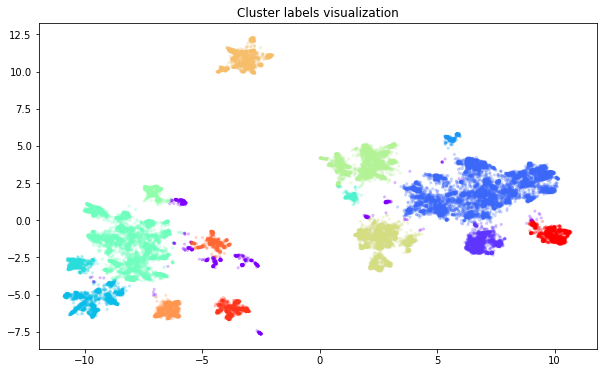

In [110]:
# visualize cluster labels
plt.figure(figsize=(10,6))
plt.title('Cluster labels visualization')
plt.scatter(
    x=umap2[:,0],
    y=umap2[:,1],
    c=DBSCAN_labels,
    cmap='rainbow',
    alpha=0.2,
    s=5,
)
pass

###### DBSCAN +  SelectKBest

In [25]:
db = DBSCAN(
    eps=0.5,
    min_samples=200,
    n_jobs=-1,
)
DBSCAN_labels = pd.Series( db.fit_predict(SelectKBest(f_classif, k=20).fit_transform(X, y)))

check_score.check_newData(pd.concat([X , DBSCAN_labels], axis =1) , y)
print('y corr : ' + str(y.corr(DBSCAN_labels) ))

DBSCAN_info =  pd.DataFrame()
DBSCAN_info['target_mean'] = [ np.mean( y[DBSCAN_labels == el]) for el in (DBSCAN_labels).unique() ]
DBSCAN_info['amount'] = [(DBSCAN_labels == el).sum() for el in np.unique(DBSCAN_labels) ]
DBSCAN_info


lr : -0.00011943104299305674 (0.7254293255807396)
rf : 0.0008357162949373942 (0.7173195189522389)
lgb : 0.001540561482322289 (0.7380130032797885)
xgb : -0.0010012857142857046 (0.7373925714285715)
y corr : -0.04201756089215707


,target_mean,amount
0,0.260911,5224
1,0.311718,879
2,0.141599,1363
3,0.176543,810
4,0.093645,897
5,0.119679,1245
6,0.171752,5735
7,0.105836,7436
8,0.419602,653
9,0.093071,967


###### HDBSCAN + UMAP

In [115]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=True, leaf_size=1, #memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=200, #min_samples=None, p=None
                           )
hdbscan_umap_label = pd.Series( clusterer.fit_predict( umap2) )

check_score.check_newData(pd.concat([X , hdbscan_label], axis =1) , y)
print('y corr : ' + str(y.corr(hdbscan_label) ))

hdbscan_info =  pd.DataFrame()
hdbscan_info['target_mean'] = [ np.mean( y[hdbscan_label == el]) for el in (hdbscan_label).unique() ]
hdbscan_info['amount'] = [(hdbscan_label == el).sum() for el in np.unique(hdbscan_label) ]
hdbscan_info

lr : 0.00022715327240230287 (0.7257759098961349)
rf : 0.003070432753907948 (0.7195542354112094)
lgb : 0.0014557281586338178 (0.7379281699561)
xgb : -0.001315285714285741 (0.7370785714285715)
y corr : 0.06823896008719106


,target_mean,amount
0,0.364706,449
1,0.227015,1792
2,0.476667,9537
3,0.105484,1530
4,0.101818,913
5,0.117730,847
6,0.134593,1169
7,0.183452,2671
8,0.164621,300
9,0.199343,7951


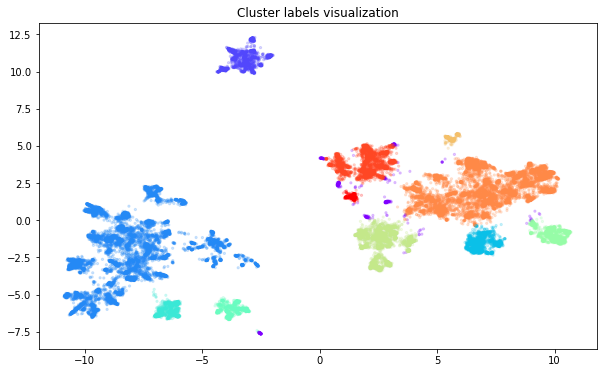

In [116]:
# visualize cluster labels
plt.figure(figsize=(10,6))
plt.title('Cluster labels visualization')
plt.scatter(
    x=umap2[:,0],
    y=umap2[:,1],
    c=hdbscan_label,
    cmap='rainbow',
    alpha=0.2,
    s=5,
)
pass

###### HDBSCAN + SelectKBest

In [27]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,
    gen_min_span_tree=True, leaf_size=1, #memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=500, #min_samples=None, p=None
                           )
hdbscan_label = pd.Series( clusterer.fit_predict( pd.DataFrame(SelectKBest(f_classif, k=20).fit_transform(X, y)) ) )

check_score.check_newData(pd.concat([X , hdbscan_label], axis =1) , y)
print('y corr : ' + str(y.corr(hdbscan_label) ))

hdbscan_info =  pd.DataFrame()
hdbscan_info['target_mean'] = [ np.mean( y[hdbscan_label == el]) for el in (hdbscan_label).unique() ]
hdbscan_info['amount'] = [(hdbscan_label == el).sum() for el in np.unique(hdbscan_label) ]
hdbscan_info

lr : 0.00045530136711013913 (0.7260040579908428)
rf : 0.0031949240568712733 (0.7196787267141728)
lgb : -0.0010189105450730818 (0.7354535312523931)
xgb : -0.0007567142857144438 (0.7376371428571428)
y corr : -0.01121635778488169


,target_mean,amount
0,0.248987,6169
1,0.311718,1435
2,0.184061,749
3,0.177045,1211
4,0.092694,1763
5,0.145207,7596
6,0.171829,917
7,0.105055,767
8,0.445928,749
9,0.103220,1581


---

In [117]:
xgb_parameters = {
    #default
    'objective': 'binary:logistic',
    'eta': 0.01, 
    'silent': 1,
    "nthread": -1,
    "random_seed": 42,
    "eval_metric": 'auc',
    
    # regularization parameters
    'max_leaves': 63,
    'max_depth': 25,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    
    #lightgbm approach
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'predictor':'cpu_predictor'
}
xgb_train = xgb.DMatrix(pd.concat([X , hdbscan_umap_label] , axis =1), y)

results = xgb.cv(xgb_parameters, xgb_train, 10000,folds= list(skf.split(X,y)),
                 early_stopping_rounds=100 ,)

xgb_rounds = pd.Series( results['test-auc-mean']).idxmax()+1
max(results['test-auc-mean']) , xgb_rounds

[0]	train-auc:0.705257+0.00377554	test-auc:0.682209+0.00709697
[1]	train-auc:0.725246+0.0041065	test-auc:0.695026+0.0088251
[2]	train-auc:0.733198+0.0033401	test-auc:0.701718+0.00804356
[3]	train-auc:0.737248+0.00404518	test-auc:0.705358+0.00741727
[4]	train-auc:0.741142+0.00378655	test-auc:0.709286+0.00679903
[5]	train-auc:0.744151+0.00444089	test-auc:0.710704+0.00579013
[6]	train-auc:0.745358+0.00400465	test-auc:0.712609+0.00543772
[7]	train-auc:0.746687+0.00428064	test-auc:0.713115+0.00489418
[8]	train-auc:0.747441+0.00419429	test-auc:0.712732+0.00541987
[9]	train-auc:0.748109+0.00393872	test-auc:0.712191+0.00499066
[10]	train-auc:0.749119+0.0042984	test-auc:0.712835+0.00480273
[11]	train-auc:0.749793+0.00404575	test-auc:0.713704+0.00506348
[12]	train-auc:0.750439+0.00427605	test-auc:0.714359+0.00471684
[13]	train-auc:0.750754+0.00446871	test-auc:0.715019+0.00449873
[14]	train-auc:0.751603+0.00426302	test-auc:0.715973+0.0048095
[15]	train-auc:0.752182+0.00396461	test-auc:0.716163+0.

[129]	train-auc:0.787339+0.00157391	test-auc:0.729051+0.00634608
[130]	train-auc:0.787593+0.00164345	test-auc:0.729177+0.00630293
[131]	train-auc:0.787902+0.00156863	test-auc:0.729193+0.00632579
[132]	train-auc:0.788257+0.00154049	test-auc:0.72934+0.00640897
[133]	train-auc:0.788586+0.00156654	test-auc:0.729454+0.00632727
[134]	train-auc:0.788925+0.00150994	test-auc:0.729563+0.00628459
[135]	train-auc:0.789206+0.00149467	test-auc:0.72959+0.00626571
[136]	train-auc:0.789458+0.00148436	test-auc:0.729582+0.00630911
[137]	train-auc:0.789889+0.00145829	test-auc:0.729749+0.00636771
[138]	train-auc:0.790177+0.00143936	test-auc:0.729824+0.00634762
[139]	train-auc:0.790489+0.00142521	test-auc:0.729919+0.00637215
[140]	train-auc:0.790766+0.00150306	test-auc:0.729944+0.00633154
[141]	train-auc:0.791086+0.00147851	test-auc:0.730031+0.006378
[142]	train-auc:0.79132+0.00147174	test-auc:0.730057+0.00636249
[143]	train-auc:0.791647+0.00152839	test-auc:0.730125+0.00644116
[144]	train-auc:0.792013+0.001

[256]	train-auc:0.828742+0.00102673	test-auc:0.737835+0.0066307
[257]	train-auc:0.829063+0.00101942	test-auc:0.737885+0.00662334
[258]	train-auc:0.829365+0.00106721	test-auc:0.737913+0.0065798
[259]	train-auc:0.829702+0.000982933	test-auc:0.73791+0.00656874
[260]	train-auc:0.830028+0.000986144	test-auc:0.737979+0.00657506
[261]	train-auc:0.830345+0.000988206	test-auc:0.738048+0.00658085
[262]	train-auc:0.83064+0.000985416	test-auc:0.738128+0.00662772
[263]	train-auc:0.830958+0.000986014	test-auc:0.738145+0.00662628
[264]	train-auc:0.831222+0.00100584	test-auc:0.738173+0.00665531
[265]	train-auc:0.831551+0.000998457	test-auc:0.738207+0.00666829
[266]	train-auc:0.831831+0.000977584	test-auc:0.738289+0.00665417
[267]	train-auc:0.832124+0.000940884	test-auc:0.738362+0.00667928
[268]	train-auc:0.832455+0.000931042	test-auc:0.738409+0.00666417
[269]	train-auc:0.832772+0.000930632	test-auc:0.738533+0.00667952
[270]	train-auc:0.83306+0.000924852	test-auc:0.738538+0.00663497
[271]	train-auc:0.8

[383]	train-auc:0.864659+0.0010013	test-auc:0.7424+0.00729079
[384]	train-auc:0.86491+0.00101378	test-auc:0.742431+0.00727637
[385]	train-auc:0.865157+0.00102826	test-auc:0.742477+0.00726338
[386]	train-auc:0.865398+0.00102223	test-auc:0.742561+0.00723714
[387]	train-auc:0.865647+0.00102378	test-auc:0.742623+0.0072204
[388]	train-auc:0.865904+0.000996687	test-auc:0.742686+0.00722286
[389]	train-auc:0.866158+0.000964929	test-auc:0.742699+0.00719288
[390]	train-auc:0.866365+0.000954288	test-auc:0.742703+0.00715984
[391]	train-auc:0.866623+0.000973831	test-auc:0.742742+0.00711014
[392]	train-auc:0.866865+0.000960761	test-auc:0.742777+0.00710187
[393]	train-auc:0.867095+0.000970983	test-auc:0.742797+0.00710268
[394]	train-auc:0.86737+0.000973741	test-auc:0.742858+0.00715054
[395]	train-auc:0.867643+0.000980362	test-auc:0.742907+0.00719496
[396]	train-auc:0.867893+0.000975074	test-auc:0.742933+0.00721947
[397]	train-auc:0.868158+0.000961181	test-auc:0.742932+0.00724454
[398]	train-auc:0.868

[510]	train-auc:0.89332+0.000990666	test-auc:0.744833+0.00697544
[511]	train-auc:0.893542+0.00101704	test-auc:0.744831+0.00696979
[512]	train-auc:0.893743+0.00100497	test-auc:0.744837+0.00695195
[513]	train-auc:0.89397+0.00101143	test-auc:0.744849+0.00695868
[514]	train-auc:0.894174+0.00101606	test-auc:0.744882+0.00694819
[515]	train-auc:0.894369+0.001019	test-auc:0.744834+0.00699101
[516]	train-auc:0.894587+0.00103143	test-auc:0.74483+0.00696516
[517]	train-auc:0.89476+0.00102571	test-auc:0.744844+0.00697906
[518]	train-auc:0.894954+0.00102119	test-auc:0.744855+0.00697185
[519]	train-auc:0.895145+0.00103298	test-auc:0.744876+0.00695223
[520]	train-auc:0.895344+0.00104499	test-auc:0.744876+0.00691915
[521]	train-auc:0.895523+0.00105033	test-auc:0.744859+0.00693211
[522]	train-auc:0.895713+0.00104781	test-auc:0.744894+0.00693087
[523]	train-auc:0.8959+0.00105677	test-auc:0.744917+0.00695704
[524]	train-auc:0.896089+0.00106027	test-auc:0.744934+0.00692203
[525]	train-auc:0.896284+0.00107

[636]	train-auc:0.915201+0.000888403	test-auc:0.745554+0.00706937
[637]	train-auc:0.915352+0.000886111	test-auc:0.745538+0.0070722
[638]	train-auc:0.915504+0.000891014	test-auc:0.745538+0.00705941
[639]	train-auc:0.915664+0.000881458	test-auc:0.745555+0.00706778
[640]	train-auc:0.915808+0.000874188	test-auc:0.745543+0.00705834
[641]	train-auc:0.915962+0.000887926	test-auc:0.745575+0.00706427
[642]	train-auc:0.916114+0.000888047	test-auc:0.745612+0.00708255
[643]	train-auc:0.916266+0.000895374	test-auc:0.745607+0.00710264
[644]	train-auc:0.916423+0.000883876	test-auc:0.745584+0.00704932
[645]	train-auc:0.916556+0.000876287	test-auc:0.745588+0.00706831
[646]	train-auc:0.916719+0.000868384	test-auc:0.745567+0.00709363
[647]	train-auc:0.916864+0.000862531	test-auc:0.745602+0.00709101
[648]	train-auc:0.917021+0.000859873	test-auc:0.745606+0.00707543
[649]	train-auc:0.91716+0.000863207	test-auc:0.745612+0.00705648
[650]	train-auc:0.917298+0.000867272	test-auc:0.745604+0.00703581
[651]	train-

[761]	train-auc:0.932361+0.000699353	test-auc:0.745903+0.00729403
[762]	train-auc:0.932479+0.000694973	test-auc:0.745885+0.00726204
[763]	train-auc:0.9326+0.000696669	test-auc:0.74586+0.00727111
[764]	train-auc:0.932725+0.0006943	test-auc:0.745842+0.007278
[765]	train-auc:0.93284+0.000687882	test-auc:0.745828+0.00730062
[766]	train-auc:0.932953+0.000685676	test-auc:0.745855+0.00730935
[767]	train-auc:0.933085+0.000672628	test-auc:0.745871+0.00730862
[768]	train-auc:0.933196+0.00067551	test-auc:0.74589+0.00729389
[769]	train-auc:0.933304+0.00067421	test-auc:0.745885+0.00728556
[770]	train-auc:0.933426+0.000674895	test-auc:0.745897+0.00725902
[771]	train-auc:0.933548+0.00068773	test-auc:0.745888+0.00727445
[772]	train-auc:0.933664+0.000688758	test-auc:0.745873+0.00726405
[773]	train-auc:0.933776+0.000683517	test-auc:0.745847+0.00726205
[774]	train-auc:0.933893+0.000683447	test-auc:0.745841+0.0072668
[775]	train-auc:0.934025+0.000688491	test-auc:0.745834+0.00726113
[776]	train-auc:0.93414

[887]	train-auc:0.945887+0.000567753	test-auc:0.745885+0.00718868
[888]	train-auc:0.945978+0.000565486	test-auc:0.745854+0.00718575
[889]	train-auc:0.946064+0.00055316	test-auc:0.745869+0.00722216
[890]	train-auc:0.946172+0.000548671	test-auc:0.745843+0.00720425
[891]	train-auc:0.946274+0.000547275	test-auc:0.745864+0.00718416
[892]	train-auc:0.946372+0.000557723	test-auc:0.745888+0.00718629
[893]	train-auc:0.946483+0.00056137	test-auc:0.745906+0.00722526
[894]	train-auc:0.946582+0.00056046	test-auc:0.745912+0.00723514
[895]	train-auc:0.94667+0.000555995	test-auc:0.745896+0.00722976
[896]	train-auc:0.946757+0.000553285	test-auc:0.745908+0.00725479
[897]	train-auc:0.946858+0.000554037	test-auc:0.74589+0.00725164
[898]	train-auc:0.946948+0.000564428	test-auc:0.74588+0.00728472
[899]	train-auc:0.947037+0.000577853	test-auc:0.745863+0.00726592
[900]	train-auc:0.947129+0.000577171	test-auc:0.745865+0.0072682
[901]	train-auc:0.947218+0.000583055	test-auc:0.745869+0.0072771
[902]	train-auc:0.

(0.7459632857142857, 878)

# 3 / Feature Selection

###### VarianceThreshold

In [28]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

In [29]:
X_varth = VarianceThreshold(.1).fit_transform(X)
print(X_varth.shape)
check_score.check_newData(X_varth , y)

(30254, 46)
lr : -0.03253569446599558 (0.6930130621577371)
rf : -0.00642187353609891 (0.7100619291212026)
lgb : -0.01733994203601763 (0.7191324997614486)
xgb : -0.018819428571428598 (0.7195744285714286)


In [30]:
X_varth = VarianceThreshold(.05).fit_transform(X)
print(X_varth.shape)
check_score.check_newData(X_varth , y)

(30254, 78)
lr : -0.021086018231552206 (0.7044627383921804)
rf : 0.0011588438487389885 (0.7176426465060405)
lgb : -0.006124731945551298 (0.7303477098519149)
xgb : -0.007239571428571456 (0.7311542857142858)


In [31]:
X_varth = VarianceThreshold(.01).fit_transform(X)
print(X_varth.shape)
check_score.check_newData(X_varth , y)

(30254, 183)
lr : -0.0008490294472572879 (0.7246997271764754)
rf : 0.004364054571259657 (0.7208478572285612)
lgb : -0.0005931650115795772 (0.7358792767858866)
xgb : -0.0019660000000000233 (0.7364278571428572)


In [32]:
X_varth = VarianceThreshold(.005).fit_transform(X)
print(X_varth.shape)
check_score.check_newData(X_varth , y)

(30254, 232)
lr : 0.00041249898984552225 (0.7259612556135782)
rf : 0.0004955317693157157 (0.7169793344266172)
lgb : -0.00018707560929409617 (0.7362853661881721)
xgb : -0.001955428571428608 (0.7364384285714286)


###### SelectKBest

In [33]:
X_KBest = SelectKBest(f_classif, k=50).fit_transform(X, y)
check_score.check_newData(X_KBest , y)

lr : -0.015337082993940543 (0.7102116736297921)
rf : -0.000838138987400705 (0.7156456636699008)
lgb : -0.011804997863945954 (0.7246674439335202)
xgb : -0.014979857142857211 (0.723414)


In [34]:
X_KBest = SelectKBest(f_classif, k=100).fit_transform(X, y)
check_score.check_newData(X_KBest , y)

lr : -0.0016659038462430997 (0.7238828527774895)
rf : 0.007160200707920561 (0.723644003365222)
lgb : -0.0006022221011093842 (0.7358702196963568)
xgb : -0.0024054285714285584 (0.7359884285714287)


In [35]:
X_KBest = SelectKBest(f_classif, k=200).fit_transform(X, y)
check_score.check_newData(X_KBest , y)

lr : 0.0023980278575750358 (0.7279467844813077)
rf : 0.0027407789690769846 (0.7192245816263785)
lgb : 0.0034638170173936222 (0.7399362588148598)
xgb : 0.0014370000000000216 (0.7398308571428572)


In [39]:
X_KBest = SelectKBest(f_classif, k=250).fit_transform(X, y)
check_score.check_newData(X_KBest , y)

lr : 0.0017372485859415976 (0.7272860052096742)
rf : 0.002196562428715909 (0.7186803650860174)
lgb : 0.0007456774698934021 (0.7372181192673596)
xgb : -0.000707571428571474 (0.7376862857142857)


In [36]:
X_KBest = SelectKBest(f_classif, k=300).fit_transform(X, y)
check_score.check_newData(X_KBest , y)

lr : 0.0005548241344380811 (0.7261035807581707)
rf : 0.0003970366060120911 (0.7168808392633136)
lgb : 0.0007346485809279768 (0.7372070903783942)
xgb : 0.000667714285714216 (0.7390615714285714)


###### SequentialFeatureSelector ДОЛГО!!!!

---

In [135]:
selectKB = SelectKBest(f_classif, k=300)
X_KBest_300 = selectKB.fit_transform(X, y)
test_X_KBest_300 = selectKB.transform(test_X)

In [133]:
xgb_parameters = {
    #default
    'objective': 'binary:logistic',
    'eta': 0.01, 
    'silent': 1,
    "nthread": -1,
    "random_seed": 42,
    "eval_metric": 'auc',
    
    # regularization parameters
    'max_leaves': 63,
    'max_depth': 25,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    
    #lightgbm approach
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'predictor':'cpu_predictor'
}
xgb_train = xgb.DMatrix(X_KBest_300, y)

results = xgb.cv(xgb_parameters, xgb_train, 10000,folds= list(skf.split(X_KBest_300,y)),
                 early_stopping_rounds=100 ,verbose_eval=1 ,)

xgb_rounds = pd.Series( results['test-auc-mean']).idxmax()+1
max(results['test-auc-mean']) , xgb_rounds

[0]	train-auc:0.703226+0.00465278	test-auc:0.676284+0.00484835
[1]	train-auc:0.724761+0.00432673	test-auc:0.695114+0.00418361
[2]	train-auc:0.734099+0.00423024	test-auc:0.703576+0.00481866
[3]	train-auc:0.737477+0.00439186	test-auc:0.705897+0.00398095
[4]	train-auc:0.740652+0.0041189	test-auc:0.70893+0.00472402
[5]	train-auc:0.742452+0.00386465	test-auc:0.70966+0.00519575
[6]	train-auc:0.744161+0.00390981	test-auc:0.711441+0.00543436
[7]	train-auc:0.745699+0.00372781	test-auc:0.712354+0.00587182
[8]	train-auc:0.746856+0.00327536	test-auc:0.713446+0.0062051
[9]	train-auc:0.747757+0.0032435	test-auc:0.714132+0.00684427
[10]	train-auc:0.748531+0.00255602	test-auc:0.7152+0.00694245
[11]	train-auc:0.749257+0.00261339	test-auc:0.715561+0.00702268
[12]	train-auc:0.750072+0.00248668	test-auc:0.715213+0.0073034
[13]	train-auc:0.750675+0.00265696	test-auc:0.715407+0.00721509
[14]	train-auc:0.751092+0.00245579	test-auc:0.715764+0.00705341
[15]	train-auc:0.751719+0.00227289	test-auc:0.716143+0.006

[129]	train-auc:0.787337+0.0016652	test-auc:0.729305+0.00615514
[130]	train-auc:0.787601+0.00164598	test-auc:0.72939+0.00614448
[131]	train-auc:0.787939+0.00160724	test-auc:0.729496+0.00614956
[132]	train-auc:0.788297+0.00163968	test-auc:0.72958+0.00614743
[133]	train-auc:0.788622+0.00160683	test-auc:0.729687+0.00611434
[134]	train-auc:0.788943+0.00154804	test-auc:0.729818+0.00612028
[135]	train-auc:0.789294+0.00155823	test-auc:0.729901+0.00610895
[136]	train-auc:0.789651+0.00156659	test-auc:0.729948+0.0060797
[137]	train-auc:0.790012+0.0015661	test-auc:0.730066+0.00605178
[138]	train-auc:0.790339+0.00166171	test-auc:0.730175+0.00605001
[139]	train-auc:0.790697+0.00158006	test-auc:0.730352+0.00609433
[140]	train-auc:0.790895+0.00161471	test-auc:0.730404+0.00610788
[141]	train-auc:0.79115+0.00162239	test-auc:0.730478+0.00611971
[142]	train-auc:0.79152+0.00170491	test-auc:0.730577+0.00613698
[143]	train-auc:0.791791+0.00168362	test-auc:0.730657+0.00611112
[144]	train-auc:0.792089+0.00171

[256]	train-auc:0.828636+0.000981458	test-auc:0.737411+0.00658908
[257]	train-auc:0.828987+0.000958593	test-auc:0.737482+0.00659789
[258]	train-auc:0.829301+0.000924153	test-auc:0.737521+0.00659141
[259]	train-auc:0.829639+0.000928515	test-auc:0.737626+0.00658069
[260]	train-auc:0.829935+0.000976776	test-auc:0.737687+0.00659597
[261]	train-auc:0.830253+0.000951168	test-auc:0.737718+0.00655468
[262]	train-auc:0.830534+0.000954406	test-auc:0.73776+0.00655542
[263]	train-auc:0.830862+0.000942746	test-auc:0.737797+0.00657338
[264]	train-auc:0.831171+0.000939613	test-auc:0.737841+0.00662712
[265]	train-auc:0.831485+0.000948644	test-auc:0.737872+0.0065575
[266]	train-auc:0.831789+0.000981319	test-auc:0.737904+0.00660033
[267]	train-auc:0.832119+0.000962045	test-auc:0.737952+0.00656235
[268]	train-auc:0.832409+0.000938205	test-auc:0.73795+0.00654643
[269]	train-auc:0.832685+0.000885558	test-auc:0.737997+0.00652702
[270]	train-auc:0.833014+0.000885991	test-auc:0.738052+0.00653933
[271]	train-a

[381]	train-auc:0.863724+0.000861127	test-auc:0.742072+0.00688843
[382]	train-auc:0.86394+0.00089807	test-auc:0.742114+0.00687593
[383]	train-auc:0.864165+0.000889939	test-auc:0.742152+0.00685359
[384]	train-auc:0.864417+0.000892341	test-auc:0.742163+0.00685518
[385]	train-auc:0.864663+0.000872906	test-auc:0.74221+0.00684893
[386]	train-auc:0.864916+0.000866117	test-auc:0.742239+0.00686234
[387]	train-auc:0.865159+0.000881481	test-auc:0.742284+0.00684231
[388]	train-auc:0.865387+0.000918738	test-auc:0.742296+0.00683426
[389]	train-auc:0.865623+0.000934901	test-auc:0.74234+0.00682861
[390]	train-auc:0.865881+0.00090177	test-auc:0.742361+0.0068626
[391]	train-auc:0.866139+0.000873661	test-auc:0.742326+0.00684986
[392]	train-auc:0.866378+0.000854971	test-auc:0.742323+0.00684596
[393]	train-auc:0.866621+0.000846912	test-auc:0.742312+0.00683587
[394]	train-auc:0.866839+0.000854512	test-auc:0.742343+0.00681821
[395]	train-auc:0.867087+0.00086657	test-auc:0.742417+0.00683847
[396]	train-auc:0

[506]	train-auc:0.891745+0.000774163	test-auc:0.744075+0.00680052
[507]	train-auc:0.891942+0.000783816	test-auc:0.744031+0.00679662
[508]	train-auc:0.892158+0.000774162	test-auc:0.744065+0.00679669
[509]	train-auc:0.892383+0.000773007	test-auc:0.744094+0.00680335
[510]	train-auc:0.892591+0.000752086	test-auc:0.744084+0.00681507
[511]	train-auc:0.892777+0.000741426	test-auc:0.744107+0.00680814
[512]	train-auc:0.892979+0.000730553	test-auc:0.744119+0.00678198
[513]	train-auc:0.893185+0.000732305	test-auc:0.744123+0.00678449
[514]	train-auc:0.893369+0.000718295	test-auc:0.744155+0.00678873
[515]	train-auc:0.893552+0.00070946	test-auc:0.744133+0.00677733
[516]	train-auc:0.893759+0.000703694	test-auc:0.744133+0.00678188
[517]	train-auc:0.893972+0.000710113	test-auc:0.744158+0.00678008
[518]	train-auc:0.894172+0.000727559	test-auc:0.744194+0.00678484
[519]	train-auc:0.894344+0.00074122	test-auc:0.744202+0.00679156
[520]	train-auc:0.894539+0.000754599	test-auc:0.744213+0.00678366
[521]	train-

[632]	train-auc:0.914108+0.000765133	test-auc:0.745432+0.00694576
[633]	train-auc:0.914247+0.000751954	test-auc:0.745461+0.00690254
[634]	train-auc:0.914402+0.000752122	test-auc:0.745458+0.00693684
[635]	train-auc:0.914554+0.000741355	test-auc:0.745459+0.00691612
[636]	train-auc:0.914704+0.000741156	test-auc:0.745482+0.00692032
[637]	train-auc:0.914854+0.000733627	test-auc:0.745499+0.0068962
[638]	train-auc:0.915001+0.000723278	test-auc:0.745519+0.00690087
[639]	train-auc:0.915135+0.000725659	test-auc:0.745501+0.00689016
[640]	train-auc:0.91529+0.000732906	test-auc:0.745513+0.00688785
[641]	train-auc:0.915434+0.000725444	test-auc:0.745508+0.00689891
[642]	train-auc:0.915588+0.000716813	test-auc:0.745563+0.00690488
[643]	train-auc:0.915737+0.000721056	test-auc:0.745583+0.00692766
[644]	train-auc:0.915879+0.00073669	test-auc:0.745584+0.00695281
[645]	train-auc:0.916013+0.000735474	test-auc:0.745574+0.00698902
[646]	train-auc:0.916169+0.000729066	test-auc:0.745543+0.00699576
[647]	train-a

[757]	train-auc:0.931297+0.00062671	test-auc:0.745923+0.00692442
[758]	train-auc:0.931426+0.000630533	test-auc:0.745949+0.00692096
[759]	train-auc:0.931552+0.000626854	test-auc:0.745976+0.0069184
[760]	train-auc:0.931671+0.000612554	test-auc:0.745977+0.00693479
[761]	train-auc:0.931793+0.000610707	test-auc:0.746+0.00694315
[762]	train-auc:0.931911+0.000611491	test-auc:0.746002+0.00695053
[763]	train-auc:0.932023+0.000594322	test-auc:0.746008+0.00692944
[764]	train-auc:0.932151+0.000581859	test-auc:0.746042+0.00690321
[765]	train-auc:0.932284+0.000580505	test-auc:0.746013+0.00688712
[766]	train-auc:0.932409+0.000572463	test-auc:0.746018+0.00690383
[767]	train-auc:0.932534+0.000566427	test-auc:0.746038+0.00688167
[768]	train-auc:0.932641+0.000569902	test-auc:0.746034+0.00689587
[769]	train-auc:0.932757+0.000562253	test-auc:0.746029+0.00687671
[770]	train-auc:0.932877+0.000555161	test-auc:0.746018+0.0068864
[771]	train-auc:0.932998+0.000555718	test-auc:0.746028+0.00687283
[772]	train-auc:

[882]	train-auc:0.944913+0.000505829	test-auc:0.746458+0.00702875
[883]	train-auc:0.945016+0.000501815	test-auc:0.74649+0.00703229
[884]	train-auc:0.945105+0.000497879	test-auc:0.746497+0.00705547
[885]	train-auc:0.945187+0.000500202	test-auc:0.746499+0.00703218
[886]	train-auc:0.94529+0.000498285	test-auc:0.746504+0.00704368
[887]	train-auc:0.945377+0.000500654	test-auc:0.746498+0.00703888
[888]	train-auc:0.945463+0.000499864	test-auc:0.746524+0.00701994
[889]	train-auc:0.945558+0.000508984	test-auc:0.746499+0.00701278
[890]	train-auc:0.945652+0.000507123	test-auc:0.746498+0.00702085
[891]	train-auc:0.945752+0.000508277	test-auc:0.746491+0.00702619
[892]	train-auc:0.945844+0.000514404	test-auc:0.746479+0.00701483
[893]	train-auc:0.945949+0.000517222	test-auc:0.746478+0.00700416
[894]	train-auc:0.946043+0.000525521	test-auc:0.746462+0.00701575
[895]	train-auc:0.946146+0.000521486	test-auc:0.746454+0.00701328
[896]	train-auc:0.946236+0.000521982	test-auc:0.746447+0.00700872
[897]	train-

(0.7465242857142858, 889)

In [136]:
xgb_test = xgb.DMatrix(test_X_KBest_300)
model = xgb.train(xgb_parameters, xgb_train, xgb_rounds,verbose_eval=False )
xgb_pred = pd.Series(model.predict(xgb_test))
xgb_pred.to_csv('submission_XGB_SelectKBest300.csv',header = True, index_label = True)

lb : 

# 4 / SemenovEncoding

In [41]:
min_minus_mass = pd.Series(index = X.columns[[X[el].unique().size > 2 for el in X.columns]])
for col in min_minus_mass.index:
    unique_in_col = X[col].unique()
    unique_in_col.sort()
    min_minus = 1
    for i in range(1 , unique_in_col.size):
        if unique_in_col[i] - unique_in_col[i-1] < min_minus :
            min_minus = unique_in_col[i] - unique_in_col[i-1]
    min_minus_mass[col] =  min_minus
min_minus_mass.head()

7     0.045455
13    0.000037
66    0.000010
67    0.000010
68    0.000010
dtype: float64

In [42]:

cat_X = pd.DataFrame()
test_cat_X = pd.DataFrame()
for col in min_minus_mass.index:
    tmp_Col = ( X[col]*(1/ min_minus_mass[col]) ).map(lambda x :round(x, 3) )
    if (tmp_Col != tmp_Col.astype(int)).sum() == 0:
        test_cat_X[col] = (test_X[col]*(1/ min_minus_mass[col]) ).astype(int)
        cat_X[col] = tmp_Col.astype(int)

print(cat_X.columns.size)
cat_X.columns

37


Index(['7', '66', '67', '68', '70', '71', '72', '73', '74', '75', '76', '77',
       '78', '80', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91',
       '92', '93', '106', '107', '108', '117', '119', '120', '124', '126',
       '127', '325', '341'],
      dtype='object')

In [40]:
#for col in cat_X.columns:
    #print(cat_X[col].value_counts())

In [ ]:
amount_missing_values = pd.Series([cat_X[col].max() + 1 - cat_X[col].unique().size for col in cat_X.columns],
                                    index = cat_X.columns)
amount_missing_values

In [84]:
cat_X = cat_X[cat_X.columns[amount_missing_values < 3]]
test_cat_X = test_cat_X[test_cat_X.columns[amount_missing_values < 3]]
cat_X.head()

,7,92,106,107,108,117,120,124,127,341
0,2,4,7,4,10,3,6,2,2,2
1,2,7,5,5,13,4,6,2,5,1
2,2,4,4,2,11,3,5,1,6,4
3,3,8,6,4,10,3,9,2,1,2
4,3,5,8,4,8,3,8,2,5,1


In [46]:
import time
import numpy as np

class SemenovEncoding:
    def __init__(self, C=10):
        self.C = C
        self.cpu_k = 3
        self.global_mean = 0
        self.features = 'all'
        self.cat_columns = []
        self.y = 0
        self.values = dict()

    def fit(self, data, y, features='all'):

        self.y = y
        
        if features == 'all':
            self.cat_columns = sorted([i for i in data.columns if data[i].dtype == 'O'])
            self.features = self.cat_columns
        else:
            self.features = features

        self.global_mean = np.mean(y)

        f = {'y': ['size', 'mean']}

        for col in self.features:
            self.values[col] = dict()
            temp = pd.DataFrame({'y': y, col: data[col]}).groupby([col]).agg(f)

            self.values[col] = (
                (temp['y']['mean'] * temp['y']['size'] + self.global_mean * self.C) / 
                (temp['y']['size'] + self.C)
            ).to_dict()
            
        return self.values

    def fit_transform(self, data, y, features='all', inplace=True):

        self.fit(data, y, features)
        return self.transform(data, inplace=inplace)

    def transform(self, data, inplace=True):
        import warnings

        if inplace:
            for col in self.values:
                if col in data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    data = pd.merge(data, temp, how='left').fillna(self.global_mean)
                    data[col] = data['value']
                    del data['value']
                    data[col] = data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
        else:
            new_data = data.copy()
            for col in self.values:
                if col in new_data.columns:
                    temp = pd.DataFrame.from_dict(
                        self.values[col], orient='index').reset_index()
                    temp.columns = [col, 'value']
                    new_data = pd.merge(
                        new_data, temp, how='left').fillna(self.global_mean)
                    new_data[col] = new_data['value']
                    del new_data['value']
                    new_data[col] = new_data[col].astype('float32')

                else:
                    warnings.warn('Column ' + col + ' is missed in this dataset.')
            return new_data
        
def create_new_df_with_categorical_encodings(new_train, new_train_y, new_val, cols):
    se = SemenovEncoding()
    new_skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    val_dfs = []
    for new_train_split, new_val_split in new_skf.split(new_train, new_train_y):
        se.fit(new_train.iloc[new_train_split], new_train_y.iloc[new_train_split], features=cols)
        val_dfs.append(se.transform(new_train.iloc[new_val_split], inplace=False) )
    val_dfs = pd.concat(val_dfs , axis =0).reset_index(inplace = False , drop = True)
    se.fit(new_train, new_train_y, features=cols)
    main_val = se.transform(new_val, inplace=False)
    return val_dfs, main_val

In [137]:
new_train_dfs = []
new_val_dfs = []
main_train_dfs = []

#bin_col = list(X.columns[ [X[col].unique().size == 2 for col in X.columns] ])
features_target_encode = list(cat_X.columns) #+ bin_col

for train_split, val_split in skf.split(train, y): 
    
    temp_train_dfs, temp_val_df = create_new_df_with_categorical_encodings(
        train.iloc[train_split], 
        y.iloc[train_split], 
        train.iloc[val_split], 
        features_target_encode
    )

    new_train_dfs.append( temp_train_dfs )
    new_val_dfs.append( temp_val_df )
    
    se = SemenovEncoding()
    se.fit(train.iloc[train_split], y.iloc[train_split], features_target_encode)
    main_train_dfs.append(se.transform(train.iloc[val_split], inplace=False))

main_train_dfs =pd.concat(main_train_dfs , axis = 0).reset_index(inplace = False , drop = True)
se.fit(train, y, features = features_target_encode)
main_test = se.transform(test, inplace=False)

In [147]:
def xgb_get_kf_target_encode_pred(params , num_rounds , train_dfs , val_dfs):
    #lgb_data = lgb.Dataset(data, label=target, free_raw_data=False , categorical_feature=cat_cols)
    pred = []
    for train_sp , test_sp in zip(train_dfs , val_dfs):
        temp_train = xgb.DMatrix(train_sp.drop(columns= '0') ,train_sp['0'] )
        temp_test = xgb.DMatrix(test_sp.drop(columns= '0') ,test_sp['0']  )
        temp_model = xgb.train(params, temp_train, num_rounds , 
                               #evals= [[temp_test , 'te_test']] ,
                               #early_stopping_rounds= 100 ,
                               verbose_eval= True
                              )
        pred.append( roc_auc_score( test_sp['0'] , temp_model.predict(temp_test )))
    return np.mean(pred)

---

In [148]:
xgb_parameters = {
    #default
    'objective': 'binary:logistic',
    'eta': 0.01, 
    'silent': 1,
    "nthread": -1,
    "random_seed": 42,
    "eval_metric": 'auc',
    
    # regularization parameters
    'max_leaves': 80,
    'max_depth': 24,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    
    #lightgbm approach
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'predictor':'cpu_predictor'
}
xgb_get_kf_target_encode_pred( xgb_parameters, 750 , new_train_dfs , new_val_dfs )

0.7441907179887357

In [144]:
xgb_test = xgb.DMatrix(main_test.drop(columns = '0') )
xgb_train = xgb.DMatrix(main_train_dfs.drop(columns = '0'), main_train_dfs['0'])
model = xgb.train(xgb_parameters, xgb_train, 750)
xgb_pred = pd.Series(model.predict(xgb_test))
xgb_pred.to_csv('submission_XGB_SemenovEncoding.csv',header = True, index_label = True)

# 5 / xgbfir

In [84]:
import xgbfir
import xgboost as xgb

In [85]:
#бинарная и бинарная
def create_bin_f( data ,f1 , f2):
    new_f = pd.DataFrame()
    new_f['('+f1 + 'XOR' + f2+')'] =  np.abs(data[f1]- data[f2])
    new_f['('+f1 + 'v' + f2 +')']= (data[f1]+ data[f2] > 0 ).astype(int)
    new_f['('+f1 + '*' + f2 +')']= data[f1]*data[f2]
    new_f['('+f1 + 'imp' + f2 +')']= [ 1 if (el == 0) else el2 for el , el2 in zip(data[f1] ,data[f2]) ]
    new_f['('+f2 + 'imp' + f1 +')']= [ 1 if (el == 0) else el2 for el , el2 in zip(data[f2] ,data[f1])]
    new_f['('+f1+'+'+f2+')/2'] = (data[f1]+ data[f2] )/2
    
    #удалим бесполезные
    for col in new_f.columns:
        if (new_f['('+f1+'+'+f2+')/2'] != new_f[col]/2).sum() == 0 and col != '('+f1+'+'+f2+')/2':
            new_f.drop(columns = [ str('('+f1+'+'+f2+')/2') ], inplace = True)
            break
    
    for col in new_f.columns :
        if new_f[col].unique().size == 1 or(new_f[col] != data[f1]).sum() == 0 or(new_f[col] != data[f2]).sum() == 0:
            new_f.drop(columns = col , inplace = True)
    for i ,col in enumerate( new_f.columns ):
        for col2 in new_f.columns[i+1:]:
            if (new_f[col] != new_f[col2]).sum() == 0 :
                new_f.drop(columns = col , inplace = True)
                break
                
    return new_f

In [86]:
#бинарная и не бинарная
def create_bin_number_f( data ,f1_bin , f2_number):
    new_f = pd.DataFrame()
    new_f['('+f1_bin + '*' + f2_number +')']= data[f1_bin]*data[f2_number]
    new_f['('+'(rev'+f1_bin + ')*' + f2_number +')'] = (1 - data[f1_bin])*data[f2_number]
    
    #удалим бесполезные
    for col in new_f.columns :
        if new_f[col].unique().size == 1 or(new_f[col] != data[f1_bin]).sum() == 0 or(new_f[col] != data[f2_number]).sum() == 0:
            new_f.drop(columns = col , inplace = True)
    for i ,col in enumerate( new_f.columns ):
        for col2 in new_f.columns[i+1:]:
            if (new_f[col] != new_f[col2]).sum() == 0 :
                new_f.drop(columns = col , inplace = True)
                break
    return new_f

In [87]:
def get_info_importance(data , target , xgb_parameters , name = ''):
    xgb_data = xgb.DMatrix(data, target)
    model = xgb.train(xgb_parameters, xgb_data, 700,verbose_eval=1 )
    xgbfir.saveXgbFI(model, feature_names=data.columns, OutputXlsxFile="xgbfir_"+ name +".xlsx")

In [88]:
xgb_parameters = {
    #default
    'objective': 'binary:logistic',
    'eta': 0.01, 
    'silent': 1,
    "nthread": -1,
    "random_seed": 42,
    "eval_metric": 'auc',
    
    # regularization parameters
    
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    
    #lightgbm approach
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'predictor':'cpu_predictor'
}

In [89]:
get_info_importance(X,y, xgb_parameters , '1')

In [90]:
create_bin_f(X , '338' , '339').head()

,(338v339),(338imp339),(339imp338)
0,1,0,1
1,1,0,1
2,1,0,1
3,1,1,0
4,1,1,0


In [91]:
X_new = pd.concat([X , create_bin_f(X , '338' , '339')] , axis =1)
get_info_importance(X_new,y, xgb_parameters , '2')

In [92]:
create_bin_number_f(X_new , '(338v339)' , '86').head()

,((338v339)*86),((rev(338v339))*86)
0,0.80904,0.0
1,0.46291,0.0
2,0.00000,0.0
3,0.00000,0.0
4,0.95837,0.0


In [93]:
X_new.drop(columns= '(338imp339)' , inplace=True)
X_new = pd.concat([X_new , create_bin_number_f(X_new , '(338v339)' , '86')] , axis =1)
get_info_importance(X_new,y, xgb_parameters , '3')

In [94]:
create_bin_f(X_new , '144' , '(338v339)').head()

,(144XOR(338v339)),(144v(338v339)),(144*(338v339)),(144imp(338v339)),((338v339)imp144),(144+(338v339))/2
0,0,1,1,1,1,1.0
1,1,1,0,1,0,0.5
2,1,1,0,1,0,0.5
3,1,1,0,1,0,0.5
4,0,1,1,1,1,1.0


In [95]:
X_new.drop(columns= ['(339imp338)','((rev(338v339))*86)'] , inplace=True)
X_new = pd.concat([X_new , create_bin_f(X_new , '144' , '(338v339)')] ,axis = 1)
get_info_importance(X_new,y, xgb_parameters , '4')

In [96]:
X_new.drop(columns= ['(144*(338v339))','(144imp(338v339))','((338v339)imp144)' ,] , inplace=True)
X_new.head()

,1,2,3,4,6,7,8,10,12,13,...,341,342,343,344,345,(338v339),((338v339)*86),(144XOR(338v339)),(144v(338v339)),(144+(338v339))/2
0,1,0,0,0,0,0.090909,0,1,1,0.461538,...,0.222222,1,1,1,1,1,0.80904,0,1,1.0
1,1,0,0,1,0,0.090909,0,1,1,0.187500,...,0.111111,1,1,1,0,1,0.46291,1,1,0.5
2,1,0,0,1,0,0.090909,0,1,1,0.200000,...,0.444444,1,1,1,1,1,0.00000,1,1,0.5
3,1,0,0,1,0,0.136364,0,1,1,0.000000,...,0.222222,1,1,1,0,1,0.00000,1,1,0.5
4,1,0,0,1,0,0.136364,0,1,1,0.650000,...,0.111111,1,1,1,1,1,0.95837,0,1,1.0


In [97]:
test_X_new = pd.concat([test_X , create_bin_f(test_X , '338' , '339')] , axis =1)
test_X_new.drop(columns= '(338imp339)' , inplace=True)
test_X_new = pd.concat([test_X_new , create_bin_number_f(test_X_new , '(338v339)' , '86')] , axis =1)
test_X_new.drop(columns= ['(339imp338)','((rev(338v339))*86)'] , inplace=True)
test_X_new = pd.concat([test_X_new , create_bin_f(test_X_new , '144' , '(338v339)')] , axis =1)
test_X_new.drop(columns= ['(144*(338v339))','(144imp(338v339))','((338v339)imp144)' ,] , inplace=True)

---

In [140]:
xgb_parameters = {
    #default
    'objective': 'binary:logistic',
    'eta': 0.01, 
    'silent': 1,
    "nthread": -1,
    "random_seed": 42,
    "eval_metric": 'auc',
    
    # regularization parameters
    'max_leaves': 63,
    'max_depth': 25,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    
    #lightgbm approach
    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    'predictor':'cpu_predictor'
}
xgb_train = xgb.DMatrix(X_new, y)

results = xgb.cv(xgb_parameters, xgb_train, 10000,folds= list(skf.split(X_new,y)),
                 early_stopping_rounds=100 ,verbose_eval=1 ,)

xgb_rounds = pd.Series( results['test-auc-mean']).idxmax()+1
max(results['test-auc-mean']) , xgb_rounds

[0]	train-auc:0.707201+0.00505351	test-auc:0.680729+0.00883343
[1]	train-auc:0.724027+0.00257011	test-auc:0.695588+0.00749593
[2]	train-auc:0.730033+0.00355516	test-auc:0.699335+0.00529578
[3]	train-auc:0.735264+0.00381881	test-auc:0.703904+0.00713363
[4]	train-auc:0.737728+0.00304183	test-auc:0.706403+0.00659538
[5]	train-auc:0.738716+0.00281228	test-auc:0.707329+0.00585814
[6]	train-auc:0.740169+0.0025281	test-auc:0.708529+0.00607976
[7]	train-auc:0.741711+0.00269605	test-auc:0.70969+0.00630466
[8]	train-auc:0.743463+0.00253103	test-auc:0.710388+0.00637833
[9]	train-auc:0.744326+0.00276775	test-auc:0.711383+0.00669504
[10]	train-auc:0.745244+0.00208234	test-auc:0.712564+0.00652636
[11]	train-auc:0.745968+0.00199132	test-auc:0.712832+0.00661073
[12]	train-auc:0.746571+0.00146315	test-auc:0.713526+0.00696568
[13]	train-auc:0.747065+0.00139505	test-auc:0.713691+0.00673227
[14]	train-auc:0.747716+0.00164021	test-auc:0.714314+0.00593883
[15]	train-auc:0.748165+0.00165652	test-auc:0.71396+

[129]	train-auc:0.783193+0.00115496	test-auc:0.728112+0.00546505
[130]	train-auc:0.783554+0.0011387	test-auc:0.728263+0.00547843
[131]	train-auc:0.783916+0.00116084	test-auc:0.728333+0.0054688
[132]	train-auc:0.784159+0.00118314	test-auc:0.728422+0.00541589
[133]	train-auc:0.784461+0.00117021	test-auc:0.728523+0.00545317
[134]	train-auc:0.784823+0.001123	test-auc:0.728639+0.00546539
[135]	train-auc:0.78506+0.00112395	test-auc:0.728773+0.00549589
[136]	train-auc:0.785364+0.00116873	test-auc:0.728812+0.00551236
[137]	train-auc:0.785648+0.0010922	test-auc:0.728836+0.00548017
[138]	train-auc:0.785984+0.00106633	test-auc:0.728919+0.00559227
[139]	train-auc:0.786344+0.0011196	test-auc:0.728961+0.00557742
[140]	train-auc:0.786631+0.00111784	test-auc:0.728955+0.00546345
[141]	train-auc:0.787005+0.00109371	test-auc:0.728993+0.00546789
[142]	train-auc:0.787278+0.00110976	test-auc:0.729041+0.00544737
[143]	train-auc:0.787653+0.00111443	test-auc:0.729075+0.00540937
[144]	train-auc:0.787958+0.00111

[256]	train-auc:0.824877+0.000726966	test-auc:0.73613+0.00533258
[257]	train-auc:0.825203+0.000711333	test-auc:0.736163+0.00536514
[258]	train-auc:0.825537+0.000718321	test-auc:0.736287+0.00535956
[259]	train-auc:0.825804+0.000749615	test-auc:0.736371+0.00535782
[260]	train-auc:0.826176+0.000783826	test-auc:0.73644+0.00534617
[261]	train-auc:0.82652+0.000727311	test-auc:0.736507+0.0053566
[262]	train-auc:0.826893+0.000748057	test-auc:0.736575+0.00532376
[263]	train-auc:0.827301+0.000743375	test-auc:0.736563+0.00529967
[264]	train-auc:0.827646+0.000746542	test-auc:0.736617+0.00533752
[265]	train-auc:0.827997+0.000759411	test-auc:0.736693+0.00533222
[266]	train-auc:0.828339+0.000768531	test-auc:0.736724+0.0053196
[267]	train-auc:0.828687+0.000758117	test-auc:0.736819+0.00533287
[268]	train-auc:0.829009+0.000801827	test-auc:0.73687+0.00531392
[269]	train-auc:0.829288+0.000769118	test-auc:0.736944+0.00533399
[270]	train-auc:0.829655+0.00072692	test-auc:0.736992+0.00537145
[271]	train-auc:0

[381]	train-auc:0.86237+0.000639375	test-auc:0.741431+0.00585931
[382]	train-auc:0.862632+0.000655914	test-auc:0.741425+0.00585896
[383]	train-auc:0.862889+0.000630312	test-auc:0.741471+0.00588486
[384]	train-auc:0.863152+0.000641439	test-auc:0.741466+0.00587409
[385]	train-auc:0.863394+0.000645049	test-auc:0.741488+0.00589179
[386]	train-auc:0.863649+0.000638609	test-auc:0.741525+0.00591417
[387]	train-auc:0.863869+0.000642918	test-auc:0.741543+0.00591097
[388]	train-auc:0.864148+0.000630872	test-auc:0.741555+0.00595027
[389]	train-auc:0.864435+0.000642587	test-auc:0.741602+0.00595822
[390]	train-auc:0.86468+0.000665137	test-auc:0.741607+0.00596807
[391]	train-auc:0.864963+0.000676185	test-auc:0.7416+0.00599945
[392]	train-auc:0.865244+0.000676134	test-auc:0.741631+0.00600923
[393]	train-auc:0.865516+0.000701491	test-auc:0.741682+0.00599334
[394]	train-auc:0.865764+0.000695374	test-auc:0.741683+0.00596003
[395]	train-auc:0.866042+0.000682476	test-auc:0.741717+0.00597054
[396]	train-au

[506]	train-auc:0.891189+0.000731561	test-auc:0.743763+0.00620516
[507]	train-auc:0.891397+0.000721984	test-auc:0.74373+0.00622621
[508]	train-auc:0.891621+0.000720531	test-auc:0.743742+0.00623406
[509]	train-auc:0.891813+0.000720098	test-auc:0.743734+0.00621481
[510]	train-auc:0.892009+0.000724826	test-auc:0.743784+0.0061902
[511]	train-auc:0.892226+0.000736744	test-auc:0.743768+0.00615885
[512]	train-auc:0.892423+0.000769496	test-auc:0.743757+0.00613008
[513]	train-auc:0.892587+0.000764574	test-auc:0.743787+0.00614508
[514]	train-auc:0.892802+0.000765478	test-auc:0.74378+0.0061634
[515]	train-auc:0.893008+0.000740473	test-auc:0.743759+0.00618551
[516]	train-auc:0.893199+0.000745099	test-auc:0.743759+0.00616072
[517]	train-auc:0.893403+0.000740358	test-auc:0.743756+0.00618404
[518]	train-auc:0.893591+0.000738385	test-auc:0.743801+0.00624623
[519]	train-auc:0.893792+0.000736072	test-auc:0.743798+0.00624745
[520]	train-auc:0.893988+0.000749199	test-auc:0.74382+0.00625943
[521]	train-auc

[631]	train-auc:0.913741+0.000601266	test-auc:0.744853+0.00651668
[632]	train-auc:0.9139+0.000596651	test-auc:0.744857+0.00655862
[633]	train-auc:0.914072+0.000609308	test-auc:0.744865+0.00655896
[634]	train-auc:0.914239+0.000605122	test-auc:0.744877+0.00653166
[635]	train-auc:0.914379+0.000615127	test-auc:0.744879+0.00654073
[636]	train-auc:0.914526+0.000619249	test-auc:0.744894+0.00656809
[637]	train-auc:0.914685+0.000606105	test-auc:0.744912+0.00657355
[638]	train-auc:0.914842+0.000590843	test-auc:0.744914+0.0065614
[639]	train-auc:0.915005+0.000585024	test-auc:0.74493+0.00660554
[640]	train-auc:0.915173+0.000578308	test-auc:0.744886+0.00660805
[641]	train-auc:0.91531+0.000596386	test-auc:0.744901+0.00660377
[642]	train-auc:0.915471+0.000580116	test-auc:0.744929+0.00661191
[643]	train-auc:0.915626+0.000585815	test-auc:0.744936+0.00664243
[644]	train-auc:0.915773+0.000598062	test-auc:0.744933+0.00662489
[645]	train-auc:0.915923+0.000596548	test-auc:0.744911+0.00660149
[646]	train-auc

[756]	train-auc:0.931194+0.000474842	test-auc:0.745134+0.00675646
[757]	train-auc:0.931316+0.000476373	test-auc:0.745149+0.00675309
[758]	train-auc:0.931433+0.000464825	test-auc:0.745135+0.00673771
[759]	train-auc:0.931555+0.000470304	test-auc:0.745124+0.00672749
[760]	train-auc:0.931686+0.000467656	test-auc:0.745134+0.00673826
[761]	train-auc:0.931818+0.000476705	test-auc:0.745122+0.00670885
[762]	train-auc:0.931937+0.000507656	test-auc:0.745115+0.00668872
[763]	train-auc:0.932071+0.000500848	test-auc:0.745143+0.0066588
[764]	train-auc:0.932186+0.000502903	test-auc:0.745143+0.00664799
[765]	train-auc:0.932299+0.000494439	test-auc:0.745173+0.00665694
[766]	train-auc:0.932417+0.000500706	test-auc:0.745197+0.00667515
[767]	train-auc:0.932527+0.000499027	test-auc:0.745208+0.00666194
[768]	train-auc:0.932641+0.000504308	test-auc:0.745204+0.00665855
[769]	train-auc:0.932747+0.000499799	test-auc:0.74521+0.00668623
[770]	train-auc:0.932862+0.000506956	test-auc:0.745202+0.0066774
[771]	train-a

[881]	train-auc:0.944656+0.000342028	test-auc:0.745591+0.0067476
[882]	train-auc:0.944753+0.000346503	test-auc:0.745622+0.00670715
[883]	train-auc:0.944858+0.000337392	test-auc:0.745629+0.00670272
[884]	train-auc:0.944954+0.000346258	test-auc:0.745609+0.00674916
[885]	train-auc:0.945055+0.000357194	test-auc:0.745627+0.00676232
[886]	train-auc:0.945153+0.000360293	test-auc:0.745611+0.00675016
[887]	train-auc:0.94525+0.000348784	test-auc:0.745584+0.00672188
[888]	train-auc:0.945352+0.000353891	test-auc:0.745564+0.00676967
[889]	train-auc:0.945454+0.000367896	test-auc:0.745576+0.00677769
[890]	train-auc:0.945552+0.000372645	test-auc:0.74561+0.00678976
[891]	train-auc:0.94565+0.000370943	test-auc:0.745608+0.00678389
[892]	train-auc:0.945749+0.000358298	test-auc:0.745616+0.0067867
[893]	train-auc:0.945827+0.000354494	test-auc:0.745603+0.00677545
[894]	train-auc:0.945915+0.000360862	test-auc:0.74562+0.00676704
[895]	train-auc:0.946007+0.000351389	test-auc:0.745604+0.00680138
[896]	train-auc:

[1006]	train-auc:0.955415+0.000336574	test-auc:0.7457+0.00696759
[1007]	train-auc:0.955497+0.000327285	test-auc:0.745679+0.00699985
[1008]	train-auc:0.955575+0.000333598	test-auc:0.745697+0.00699894
[1009]	train-auc:0.955657+0.000336975	test-auc:0.745691+0.00698793
[1010]	train-auc:0.955745+0.000327855	test-auc:0.745683+0.00698381
[1011]	train-auc:0.955817+0.00032461	test-auc:0.745696+0.00698845
[1012]	train-auc:0.955888+0.000328332	test-auc:0.745715+0.00698238
[1013]	train-auc:0.955952+0.000328973	test-auc:0.745716+0.00697877
[1014]	train-auc:0.956035+0.000321853	test-auc:0.745715+0.00696672
[1015]	train-auc:0.956112+0.000321075	test-auc:0.745718+0.00698119
[1016]	train-auc:0.956186+0.000315877	test-auc:0.745689+0.00696622
[1017]	train-auc:0.956254+0.000318082	test-auc:0.745688+0.00700073
[1018]	train-auc:0.956331+0.000314649	test-auc:0.745683+0.00699615
[1019]	train-auc:0.9564+0.000316135	test-auc:0.745659+0.00699027
[1020]	train-auc:0.956471+0.000320383	test-auc:0.745678+0.00700112


(0.745835857142857, 952)

In [141]:
xgb_test = xgb.DMatrix(test_X_new)
model = xgb.train(xgb_parameters, xgb_train, xgb_rounds,verbose_eval=1 )
xgb_pred = pd.Series(model.predict(xgb_test))
xgb_pred.to_csv('submission_XGB_xgbfir.csv',header = True, index_label = True)

# The End